# 04_offline_tf_cnn_lstm_notebook.ipynb
Offline Training and Evaluation of CNN+LSTM TensorFlow Model
This notebook trains a CNN+LSTM model on 5G throughput data, visualizes loss curves, computes metrics, and displays a Run 14 heatmap.

## 1. Imports and Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

# Create directories
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

## 2. Load and Preprocess Data

In [2]:
# Load dataset
df = pd.read_csv(
    "C:/Users/axxiv/Desktop/5g_throughput_dashboard/data/mm-5G-enriched.csv"
)
df.drop(columns=["debit_class"], inplace=True, errors="ignore")

# Rolling window parameters
SEQ_LEN = 10
targets = ["debit_brut", "debit_lisse"]
features = df.select_dtypes(include=[np.number]).columns.drop(targets).tolist()

# Build sequences
X, y_raw, y_smooth, runs = [], [], [], []
for run_id, grp in df.groupby("run_num"):
    grp = grp.reset_index(drop=True)
    for i in range(len(grp) - SEQ_LEN):
        X.append(grp.loc[i : i + SEQ_LEN - 1, features].values)
        y_raw.append(grp.loc[i + SEQ_LEN, "debit_brut"])
        y_smooth.append(grp.loc[i + SEQ_LEN, "debit_lisse"])
        runs.append(run_id)

X = np.stack(X)
y_raw = np.array(y_raw)
y_smooth = np.array(y_smooth)
runs = np.array(runs)

# Scale features
ns, _, nf = X.shape
scaler = MinMaxScaler()
X_flat = scaler.fit_transform(X.reshape(-1, nf))
X = X_flat.reshape(ns, SEQ_LEN, nf)

# Save scaler
joblib.dump(scaler, "models/scaler.gz")

# Train/validation split
(
    X_train,
    X_val,
    y_raw_train,
    y_raw_val,
    y_smooth_train,
    y_smooth_val,
    runs_train,
    runs_val,
) = train_test_split(
    X, y_raw, y_smooth, runs, test_size=0.2, random_state=42, shuffle=False
)

## 3. Build and Compile Model

In [3]:
input_layer = layers.Input(shape=(SEQ_LEN, nf))
x = layers.Conv1D(32, 3, padding="same", activation="relu")(input_layer)
x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64)(x)
raw_output = layers.Dense(1, name="raw")(x)
smooth_output = layers.Dense(1, name="smooth")(x)
model = models.Model(inputs=input_layer, outputs=[raw_output, smooth_output])
model.compile(optimizer="adam", loss="mse")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 25)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 32)       2432        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 10, 64)       6208        ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 5, 64)        0           ['conv1d_1[0][0]']               
                                                                                              

## 4. Train with Early Stopping

In [4]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = model.fit(
    X_train,
    [y_raw_train, y_smooth_train],
    validation_data=(X_val, [y_raw_val, y_smooth_val]),
    epochs=100,
    batch_size=32,
    callbacks=[es],
)

# Save model
model.save("models/throughput_model")
model.save_weights("models/throughput_weights.h5")

Epoch 1/100
1674/1674 [==============================] - 61s 28ms/step - loss: 844905.0000 - raw_loss: 446335.2188 - smooth_loss: 398569.7500 - val_loss: 620844.2500 - val_raw_loss: 330846.1562 - val_smooth_loss: 289998.1250
Epoch 2/100
1674/1674 [==============================] - 60s 36ms/step - loss: 673619.7500 - raw_loss: 360631.4688 - smooth_loss: 312989.5625 - val_loss: 505000.2188 - val_raw_loss: 272826.5312 - val_smooth_loss: 232173.4062
Epoch 3/100
1674/1674 [==============================] - 98s 58ms/step - loss: 549957.1250 - raw_loss: 298676.0625 - smooth_loss: 251281.0000 - val_loss: 429847.6250 - val_raw_loss: 235148.3594 - val_smooth_loss: 194699.3906
Epoch 4/100
1674/1674 [==============================] - 44s 26ms/step - loss: 455400.0938 - raw_loss: 251163.7188 - smooth_loss: 204236.5469 - val_loss: 317658.7500 - val_raw_loss: 178020.4219 - val_smooth_loss: 139638.3594
Epoch 5/100
1674/1674 [==============================] - 43s 26ms/step - loss: 330342.8125 - raw_los

INFO:tensorflow:Assets written to: models/throughput_model\assets


INFO:tensorflow:Assets written to: models/throughput_model\assets


## 5. Loss Curves Visualization

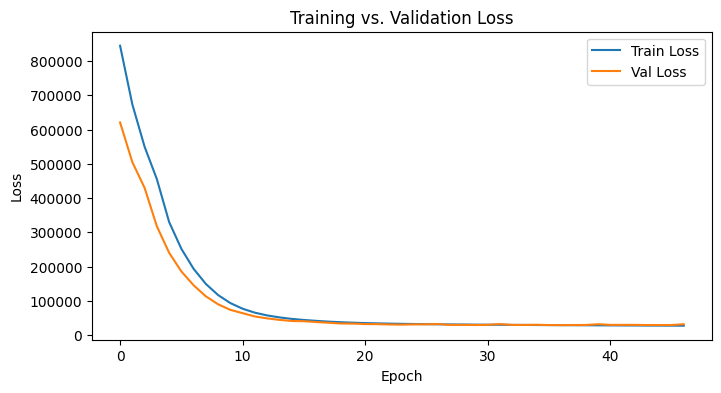

In [5]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 6. Evaluation Metrics

In [6]:
# Predictions on validation
pred_raw, pred_smooth = model.predict(X_val)
pred_raw = pred_raw.squeeze()
pred_smooth = pred_smooth.squeeze()

# Switch: choose prediction closest to true raw
pred_final = np.where(
    np.abs(pred_raw - y_raw_val) < np.abs(pred_smooth - y_raw_val),
    pred_raw,
    pred_smooth,
)

# Compute metrics
rmse_raw = np.sqrt(mean_squared_error(y_raw_val, pred_raw))
rmse_smooth = np.sqrt(mean_squared_error(y_smooth_val, pred_smooth))
rmse_final = np.sqrt(mean_squared_error(y_raw_val, pred_final))
mae_final = mean_absolute_error(y_raw_val, pred_final)
r2_final = r2_score(y_raw_val, pred_final)

# Display metrics
metrics = pd.DataFrame(
    {
        "Metric": ["RMSE Raw", "RMSE Smooth", "RMSE Final", "MAE Final", "R2 Final"],
        "Value": [rmse_raw, rmse_smooth, rmse_final, mae_final, r2_final],
    }
)
metrics

419/419 [==============================] - 9s 10ms/step


,Metric,Value
0,RMSE Raw,163.824275
1,RMSE Smooth,44.644460
2,RMSE Final,144.612867
3,MAE Final,82.117750
4,R2 Final,0.899052


## 7. Run 14 Heatmap via Folium

In [8]:
import joblib
import pickle  # ✅ Ajouté ici

# ...

# Sauvegarde des artefacts
model.save("ml_models/throughput_model.keras")
joblib.dump(scaler, "ml_models/scaler.gz")

with open("ml_models/feature_names.pkl", "wb") as f:
    pickle.dump(features, f)

In [9]:
from tensorflow import keras

model_path = "ml_models/throughput_model.keras"

try:
    model = keras.models.load_model(model_path)
    print("✅ Modèle chargé avec succès.")
except Exception as e:
    print(f"❌ Erreur lors du chargement : {e}")

✅ Modèle chargé avec succès.


In [10]:
model.save("../ml_models/throughput_model.keras")
joblib.dump(scaler, "../ml_models/scaler.gz")

with open("../ml_models/feature_names.pkl", "wb") as f:
    pickle.dump(features, f)